In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-06 12:15:03--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.156.83.10, 108.156.83.2, 108.156.83.50, ...
Connecting to segment-anything.com (segment-anything.com)|108.156.83.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.08s   

2024-03-06 12:15:04 (2.55 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)


torch.Size([3, 1365, 2048])


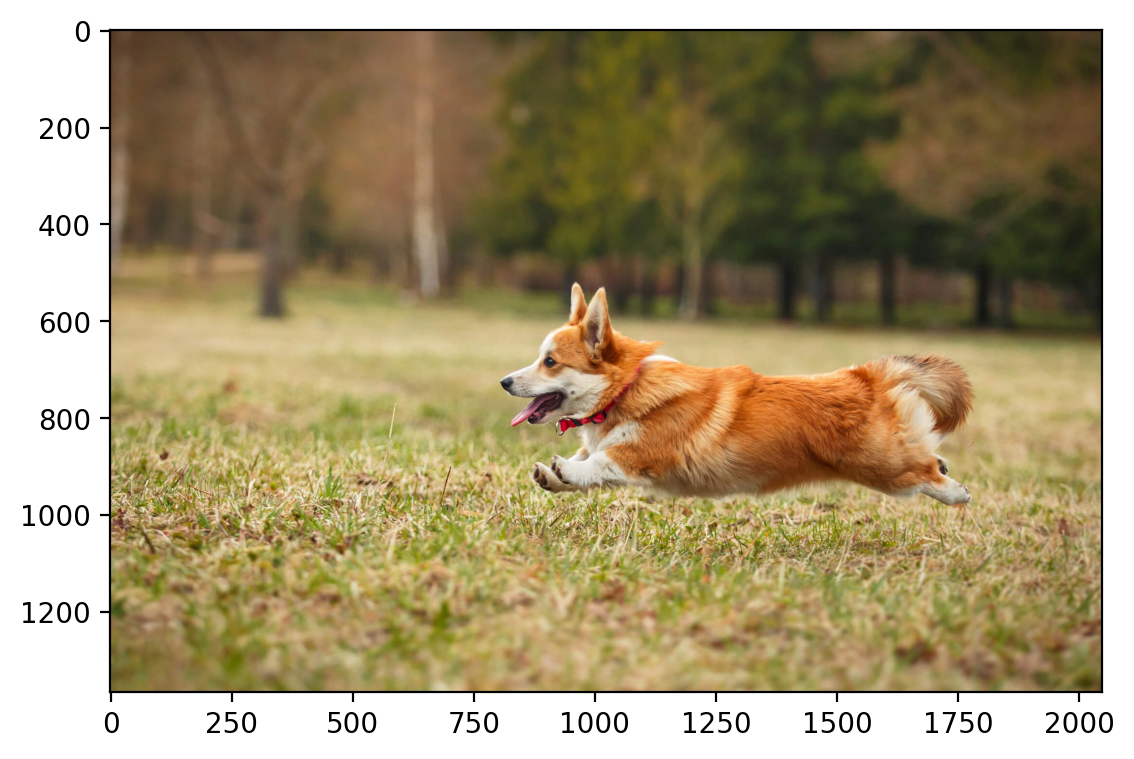

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
print(img.shape)

torch.Size([3, 1365, 2048])


In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [7]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [8]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [9]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400) # 400x400
crop.shape

torch.Size([3, 400, 400])

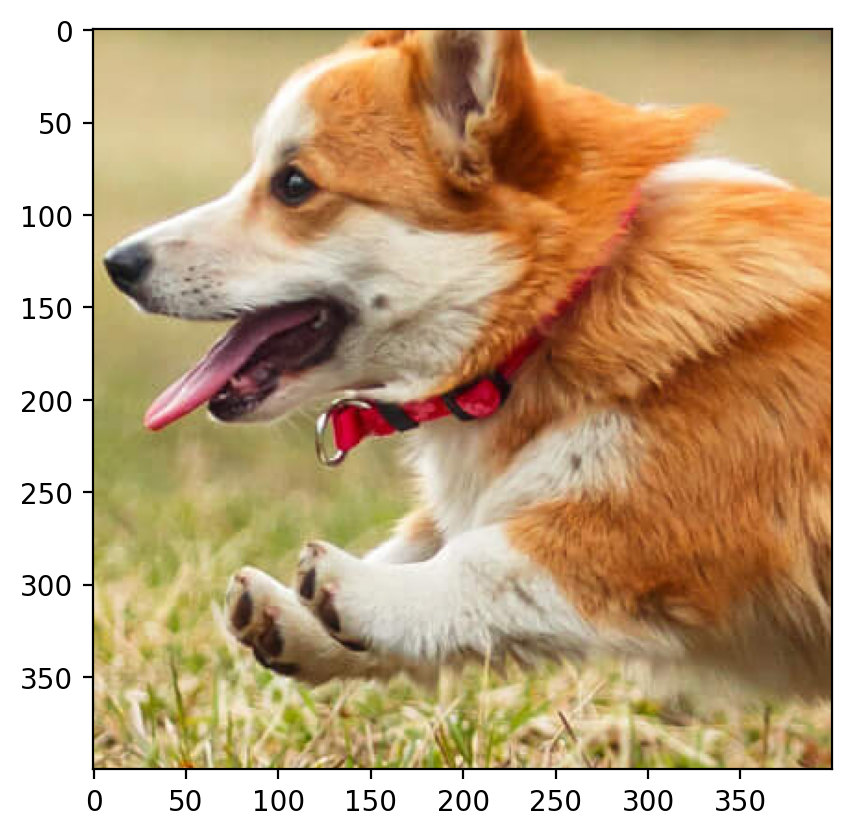

In [10]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [11]:
crop = crop.to(device)

In [12]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [13]:
crop.size()

torch.Size([3, 400, 400])

In [16]:
img_200 = transforms.Resize((200, 200))(crop) #reshaping the image to 200 X 200
img_200

tensor([[[0.7706, 0.7706, 0.7706,  ..., 0.5667, 0.5627, 0.5608],
         [0.7784, 0.7784, 0.7784,  ..., 0.5627, 0.5598, 0.5569],
         [0.7922, 0.7922, 0.7922,  ..., 0.5775, 0.5735, 0.5716],
         ...,
         [0.8980, 0.8422, 0.7118,  ..., 0.6725, 0.6422, 0.6069],
         [0.7039, 0.6520, 0.6382,  ..., 0.6431, 0.6333, 0.6304],
         [0.6529, 0.7314, 0.6275,  ..., 0.6245, 0.6814, 0.7373]],

        [[0.6961, 0.6961, 0.6961,  ..., 0.4765, 0.4725, 0.4706],
         [0.7039, 0.7039, 0.7039,  ..., 0.4882, 0.4853, 0.4824],
         [0.7176, 0.7176, 0.7176,  ..., 0.5108, 0.5069, 0.5049],
         ...,
         [0.7990, 0.7392, 0.5971,  ..., 0.4314, 0.4010, 0.3598],
         [0.5980, 0.5392, 0.5167,  ..., 0.4539, 0.4245, 0.4020],
         [0.5775, 0.6471, 0.5373,  ..., 0.5020, 0.5206, 0.5461]],

        [[0.4765, 0.4765, 0.4765,  ..., 0.3431, 0.3392, 0.3373],
         [0.4843, 0.4843, 0.4843,  ..., 0.3490, 0.3461, 0.3431],
         [0.4980, 0.4980, 0.4980,  ..., 0.3696, 0.3657, 0.

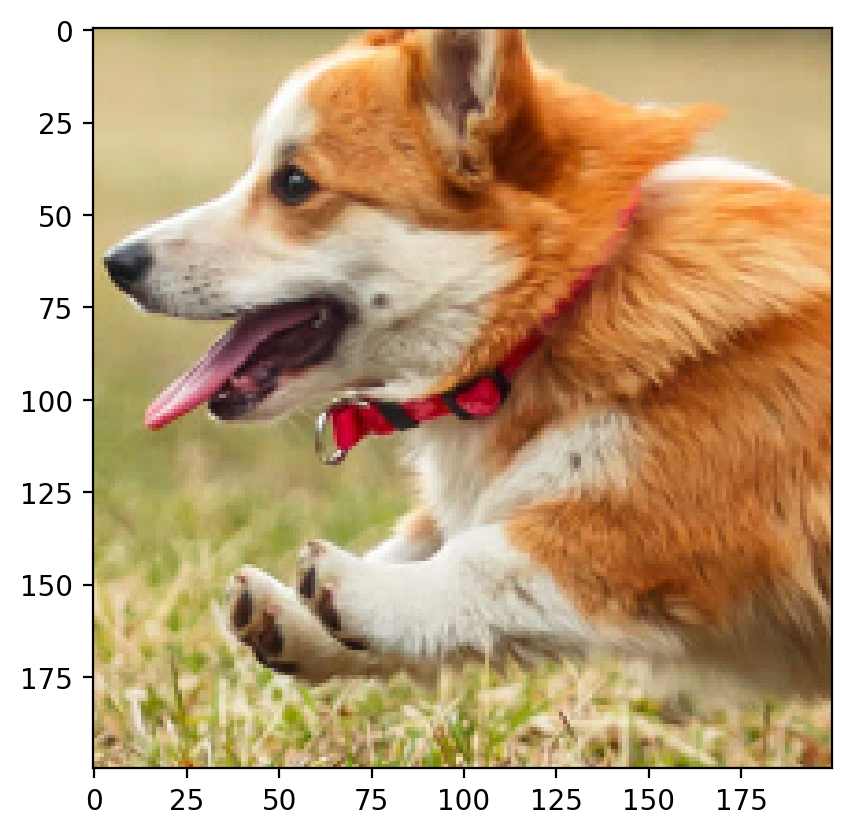

In [17]:
plt.imshow(rearrange(img_200, 'c h w -> h w c').cpu().numpy())

In [18]:
def create_coordinate_map(img):
    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [20]:
dog_X, dog_Y = create_coordinate_map(img_200)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [21]:

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [22]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [23]:
def train(net, lr, X, Y, epochs, verbose=True):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [24]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):

    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    # for a in [ax0, ax1]:
    #     a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
def RMSE(img_tensor1,img_tensor2):

  red = (img_tensor1[0][:][:] - img_tensor2[0][:][:])**2
  red_rmse = (torch.mean(red))**0.5

  green = (img_tensor1[1][:][:] - img_tensor2[1][:][:])**2
  green_rmse = (torch.mean(green))**0.5

  blue = (img_tensor1[2][:][:] - img_tensor2[2][:][:])**2
  blue_rmse = (torch.mean(blue))**0.5

  square_sum = (red_rmse**2)*red.size()[0]*red.size()[1] + (green_rmse**2)*green.size()[0]*green.size()[1] + (blue_rmse**2)*blue.size()[0]*blue.size()[1]
  rmse = (square_sum/(img_tensor1.size()[0]*img_tensor1.size()[1]*img_tensor1.size()[2]))**0.5

  return rmse.item()

In [ ]:
def Peak_SNR(img_tensor1,img_tensor2):
  peak = torch.max(img_tensor2)
  return 20*(np.log(peak.item()/RMSE(img_tensor1,img_tensor2))/np.log(10))

In [25]:
np.random.seed(42)
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [26]:
np.random.seed(42)
X_rff = create_rff_features(dog_X_scaled, 8000, 0.008)

In [27]:
X_rff.shape

torch.Size([40000, 8000])

In [ ]:
np.random.seed(42)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 1000)

Epoch 0 loss: 0.373380
Epoch 100 loss: 0.063190
Epoch 200 loss: 0.023931
Epoch 300 loss: 0.019491
Epoch 400 loss: 0.017929
Epoch 500 loss: 0.016907
Epoch 600 loss: 0.016167


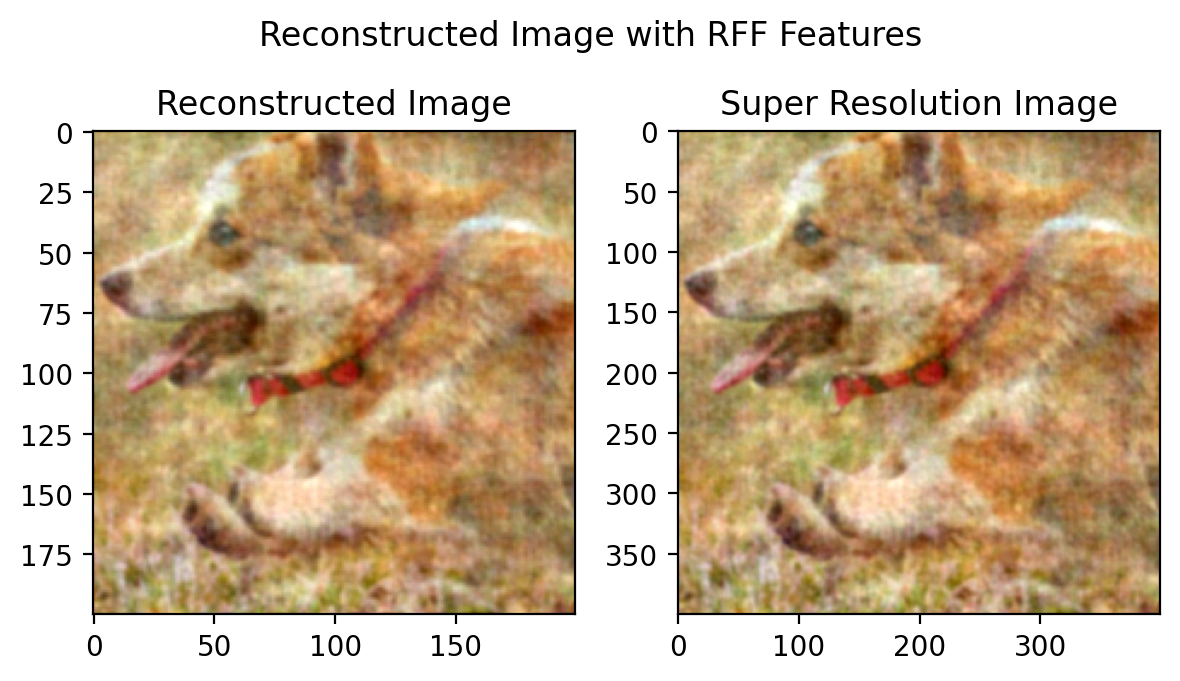

In [ ]:
np.random.seed(42)
plot_reconstructed_and_original_image(img_200, net, X_rff, title="Reconstructed Image with RFF Features")

dog_X, dog_Y = create_coordinate_map(crop)
dog_X.shape, dog_Y.shape


scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())


dog_X_scaled = scaler_X.transform(dog_X.cpu())


dog_X_scaled = torch.tensor(dog_X_scaled).to(device)


dog_X_scaled = dog_X_scaled.float()

X_rff_400 = create_rff_features(dog_X_scaled, 8000, 0.008)

super_resolution = net(X_rff_400)
super_resolution = super_resolution.reshape(400, 400, 3)

plt.imshow(super_resolution.cpu().detach().numpy())
plt.title("Super Resolution Image")
plt.show()

In [ ]:
RMSE(crop,rearrange(super_resolution, 'h w c -> c h w'))

0.12267659372865336

In [ ]:
mse = nn.MSELoss()
output = mse(crop, rearrange(super_resolution, 'h w c -> c h w'))
print("RMSE value is :", (output.cpu().detach().numpy())**0.5)

RMSE: 0.12267659372865339


In [ ]:
psnr = Peak_SNR(crop, rearrange(super_resolution, 'h w c -> c h w'))
print(f"{'PSNR value is'}:{psnr}")

Peak SNR:19.01387391058244
